In [1]:
!pip install numpy matplotlib librosa scipy plotly nbformat

In [2]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio, display
import plotly.graph_objects as go

# ============================================================================
# SECTION 1: SIGNAL GENERATION (The Physics)
# ============================================================================
# Why: Create synthetic audio signals to learn DSP fundamentals.
# What we'll build: Two pure tones at different frequencies + noise
#
# Real-world analogy: Imagine a room with a low hum (e.g., AC power at 150 Hz)
# and a bird chirping (high-pitched at 3000 Hz). We'll simulate this.
# ============================================================================

# --- Setup: Key audio parameters ---
sample_rate = 16000  # Hz (samples per second). Standard for speech/phone audio.
duration = 3  # seconds. How long is our recording?
amplitude = 0.5  # Max amplitude for our sine waves (range -1 to 1)

# --- Function: Pure sine wave generator ---
def generate_tone(freq, duration, sr=16000):
    """
    Create a pure sine wave at a given frequency.
    
    Math: y(t) = A * sin(2π*f*t)
    - A = 0.5 (Amplitude, controls loudness)
    - f = Frequency in Hz (e.g., 150 Hz = 150 cycles per second)
    - t = time array from 0 to duration
    
    Returns:
      t: time array (used for plotting)
      signal: the actual waveform (numpy array of audio samples)
    """
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    signal = amplitude * np.sin(2 * np.pi * freq * t) 
    return t, signal

# --- Create two component signals ---
t, tone_low = generate_tone(150, duration, sample_rate)  # Low tone (like AC hum)
_, tone_high = generate_tone(3000, duration, sample_rate)  # High tone (like birdsong)
audio = tone_low + tone_high  # Mix them together (linear superposition)

# --- Add realistic noise ---
# Why: Real recordings are never clean. Microphone noise, wind, etc.
noise = np.random.normal(0, 0.1, audio.shape)  # Gaussian noise: mean=0, std=0.1
noisy_audio = audio + noise  # Composite signal: tone_low + tone_high + noise

# --- Info & Playback ---
print(f"Signal Generated. shape: {noisy_audio.shape}, Sampling Rate: {sample_rate}")
print(f"  → {noisy_audio.shape[0]} samples at {sample_rate} Hz = {duration} seconds")
print(f"  → To reconstruct audio: play 16000 samples per second")

rms_manual = np.sqrt(np.mean(tone_high*2))
print(f"RMS Amplitude (Perceived Loudness): {rms_manual:.4f}")
print(f"  → Range typically 0–1 for normalized audio")
display(Audio(audio, rate=sample_rate, embed=True))

Signal Generated. shape: (48000,), Sampling Rate: 16000
  → 48000 samples at 16000 Hz = 3 seconds
  → To reconstruct audio: play 16000 samples per second
RMS Amplitude (Perceived Loudness): 0.0000
  → Range typically 0–1 for normalized audio


In [3]:
# Minimal, interactive time‑domain view of our signal components
# Why: See how the noisy composite waveform relates to its two tones.
# How: Use Plotly for hover/zoom/legend toggling with the least code.

import plotly.graph_objects as go  # Interactive plotting (already imported above in the notebook)

# 1) Pick a short time window so the plot is responsive and features are clear.
# At 16 kHz, 1000 samples ≈ 0.0625 seconds.
N = 1000

# 2) Build an interactive line plot with three traces:
#    - Noisy Signal: what you would "record" (tone_low + tone_high + noise)
#    - High Tone (3000 Hz): fast oscillations
#    - Underlying Low Tone (150 Hz): slow oscillations (dashed for contrast)
fig = go.Figure([
    go.Scatter(x=t[:N], y=noisy_audio[:N], name='Noisy Signal', opacity=0.7),
    go.Scatter(x=t[:N], y=tone_high[:N], name='High Tone (3000 Hz)', opacity=0.5),
    go.Scatter(x=t[:N], y=tone_low[:N], name='Low Tone (150 Hz)', line=dict(dash='dash'), opacity=0.9)
])

# 3) Tidy layout. Tip: Use the legend to hide/show components as you inspect.
fig.update_layout(
    title='Time Domain: Composite vs. Component Tones',
    xaxis_title='Time (s)',
    yaxis_title='Amplitude',
    width=1400,
    height=400,
    hovermode='x unified'  # One unified tooltip across traces at a given time
)

# Try this: Click a legend item to toggle visibility. Drag to zoom.
fig.show()

In [4]:
# ============================================================================
# SECTION 2: TIME DOMAIN ANALYSIS
# ============================================================================
# Why: Measure signal properties directly from time samples.
# Use case: RMS (Root Mean Square) is the "loudness" or energy metric.
# Definition: RMS is basically average amplitude over time without direction.
# Peak: measures the tallest wave in the wavform/highest amplitude.
# ============================================================================

# --- RMS Amplitude (Energy/Loudness Metric) ---
# Formula: RMS = sqrt( mean(x[n]^2) for all n )
# 
# Intuition:
#   1. Square each sample (x[n]^2) to get energy
#   2. Average the energy across all samples (mean)
#   3. Take the square root to get back to amplitude scale
#
# Why it matters:
#   - RMS is what our ears perceive as "loudness"
#   - Used in audio gain control, dynamic range, etc.
#   - In dB scale: dB = 20*log10(RMS/reference)

def rms(x):
    # Formula: RMS = sqrt( mean(x[n]^2) for all n )
    return np.sqrt(np.mean(x**2))

print("RMS tone_low             :", rms(tone_low))
print("RMS tone_high            :", rms(tone_high))
print(f"  → RMS of tone_high and tone_low remain ~ same since their amplitudes are same at {amplitude} irrespective of the number of oscillations.\n")
print("RMS Audio                :", rms(audio))
print("RMS Audio with Noise     :", rms(noisy_audio))
print("Peak Amplitude           :", np.max(np.abs(noisy_audio)))

print(f"  → Range typically 0–1 for normalized audio")

RMS tone_low             : 0.3535533905932738
RMS tone_high            : 0.3535533905932739
  → RMS of tone_high and tone_low remain ~ same since their amplitudes are same at 0.5 irrespective of the number of oscillations.

RMS Audio                : 0.49999999999999967
RMS Audio with Noise     : 0.509843108509557
Peak Amplitude           : 1.3227403637892892
  → Range typically 0–1 for normalized audio


In [ ]:

# ============================================================================
# SECTION 3: FREQUENCY DOMAIN (FFT Intuition)
# ============================================================================
# Why: Transform time-domain samples into frequency bins to see which
#      frequencies are present in our signal.
# What we'll see: A peak at 150 Hz (low tone) and 3000 Hz (high tone).
# Key insight: Hard-to-see components in time domain pop out clearly here!
# ============================================================================

# --- The FFT Transformation ---
# How: Real FFT converts our ~16000 time samples -> ~8000 frequency bins
# Math: FFT decomposes the signal into its frequency components
# Expected: Peaks where our pure tones (150 Hz, 3000 Hz) exist

fft_spectrum = np.fft.rfft(noisy_audio)
freqs = np.fft.rfftfreq(len(noisy_audio), 1 / sample_rate)
magnitude = np.abs(fft_spectrum)

# Convert to dB scale (decibels)
# Why: dB scale compresses the dynamic range and matches human hearing perception
# Formula: dB = 20 * log10(magnitude) + small offset (1e-12) to avoid log(0)
magnitude_db = 20 * np.log10(magnitude + 1e-12)

import plotly.graph_objects as go

# --- Interactive Visualization ---
# Create an interactive plot to explore the frequency spectrum
fig = go.Figure()
fig.add_trace(go.Scatter(x=freqs, y=magnitude_db, mode='lines', name='Magnitude (dB)'))

# Configure layout for clarity
fig.update_layout(
    title='Frequency Domain: FFT Magnitude (dB)',
    xaxis_title='Frequency (Hz)',
    yaxis_title='Magnitude (dB)',
    xaxis=dict(range=[0, 4000]),  # Zoom into the relevant frequency range
    width=1000,
    height=400,
)

# --- Annotate Expected Tones ---
# Visual markers to highlight where we expect peaks
# Red line: Low tone at 150 Hz (AC hum, background noise)
# Green line: High tone at 3000 Hz (bird chirp, foreground sound)
fig.add_vline(x=150, line=dict(color='red', dash='dash'), annotation_text='150 Hz', annotation_position='top left')
fig.add_vline(x=3000, line=dict(color='green', dash='dash'), annotation_text='3000 Hz', annotation_position='top right')


fig.show()


RMS Amplitude (Loudness): 0.5081


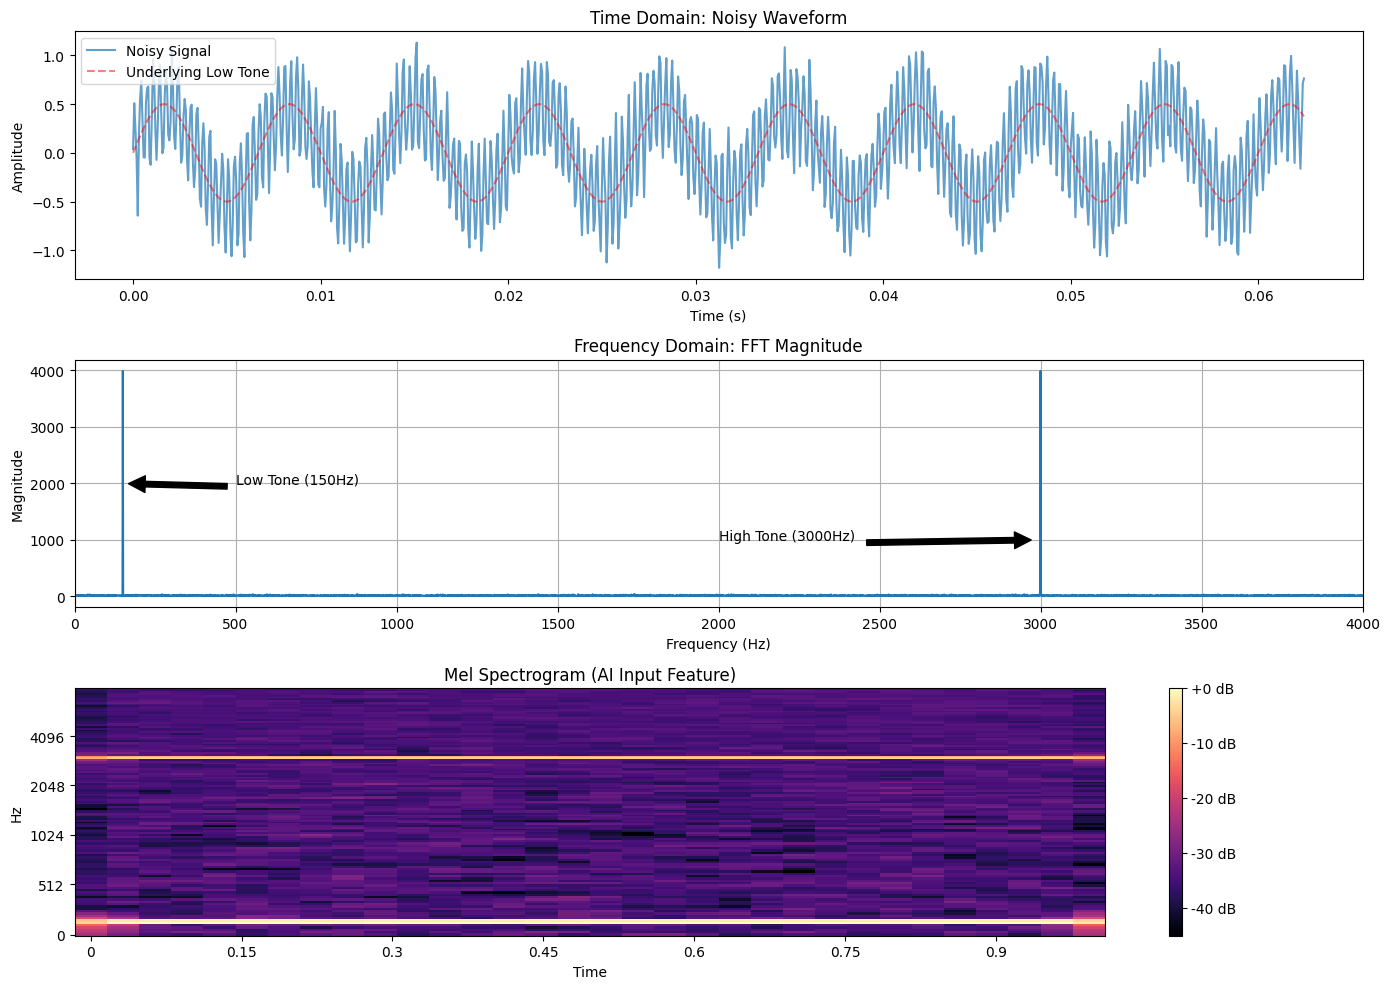


Applied Low-Pass Filter at 1000Hz.
Original RMS: 0.5081
Filtered RMS: 0.3541 (High freq energy removed)
